In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data exploration

(720, 1280, 3)


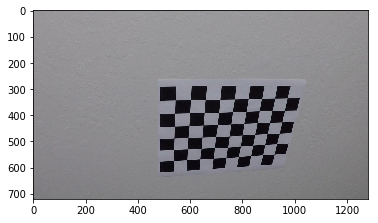

In [2]:
# Data exploration - One of the 20 images used for calibration
img = mpimg.imread("camera_cal/calibration10.jpg")
image_shape = img.shape
print(image_shape)
plt.imshow(img)

To correct the image distortions I first need to identify the locations of the corners on the camera calibration images. These are going to be inputs of my camera calibration function. I used opencv functions findChessboardCorners() and drawChessboardCorners() to do so.

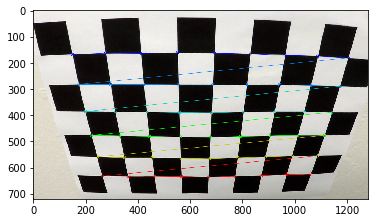

In [3]:
nx = 9
ny = 6

# Read in and make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")

#Arrays to store object points and image points from all the images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Prepare object points like (0,0,0), (1,0,0), (2,0,0) .../(7,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates

for fname in images:
    #read in each image
    img = mpimg.imread(fname)

    #Convert the image to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #Find the chessboard corners
    ret, corners = cv2. findChessboardCorners(gray, (nx,ny), None)

    #If corners are found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        #draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)

In [4]:
# Plot original and transformed image next to each other
def print_image(img1, img2, title1, title2, cmap):
    # Plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    if cmap == 'gray':
        ax2.imshow(img2,cmap = 'gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Calibration and Undistortion 

After identifying the corners I am good to calibrate the camera. To do that I use opencv's calibrateCamera() function, I pass the previously calculated objpoints, imgpoints and the shape of the image as arguments. 
The function returns the distortion coefficients and the camera matrix as well which I need to pass as arguments to the undistort() function which returns my undistorted image. Let's try out!

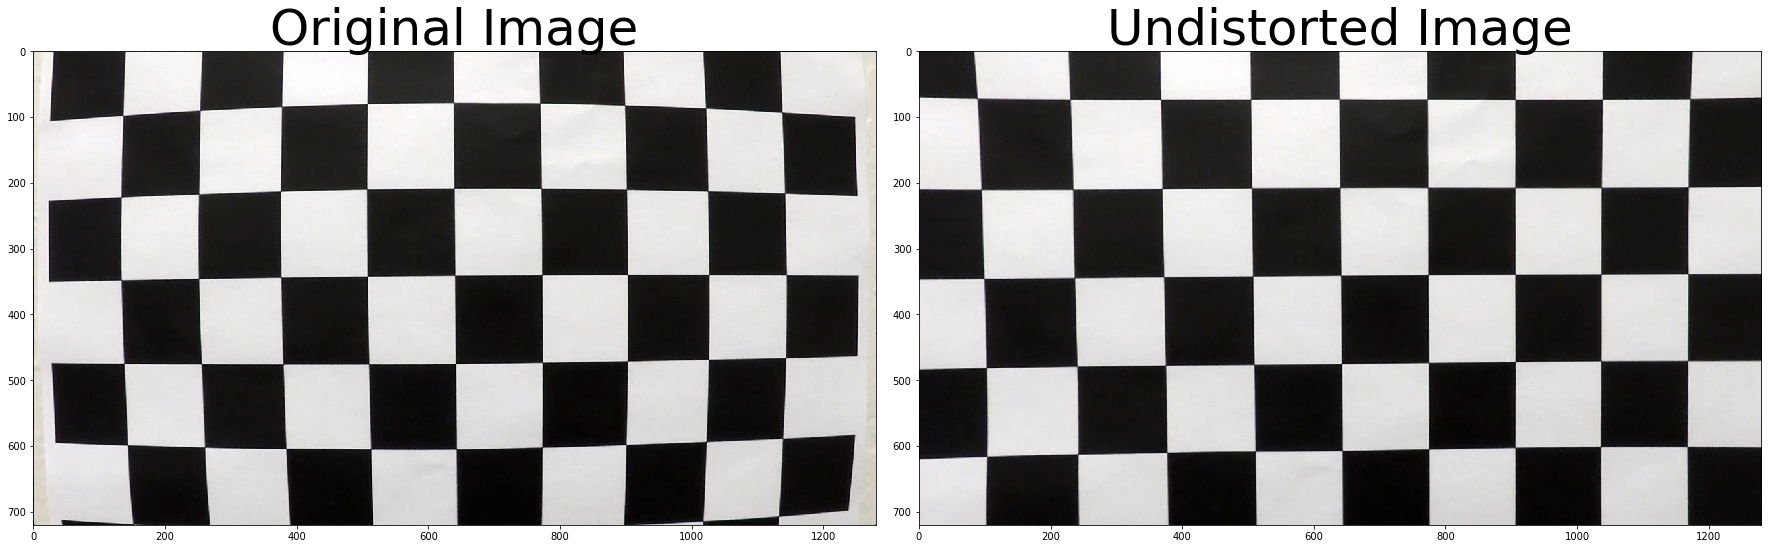

In [5]:
#Camera calibration and undistortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = mpimg.imread('camera_cal/calibration1.jpg')
dst = undistort(img)

print_image(img, dst, 'Original Image', 'Undistorted Image', 'default')

Let's test some real-life images before/after undistortion. 

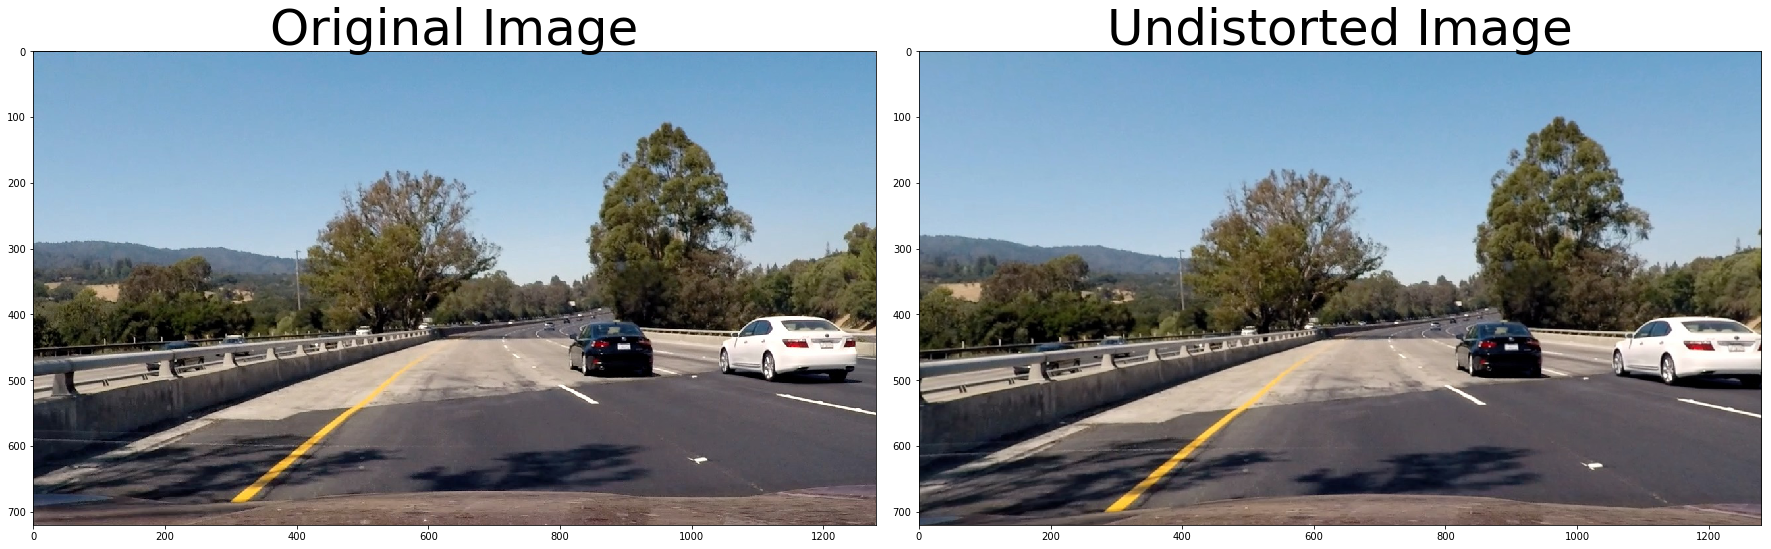

In [6]:
img = mpimg.imread('test_images/test4.jpg')
dst=undistort(img)
print_image(img, dst, 'Original Image', 'Undistorted Image', 'default')

# Perspective Transform

Perspective transform maps the points in a given image to a different, desired, image points with a new perspective. We are most interested in the bird's-eye view transform that let's us vie a lane from above, this will be useful for calculating the lane curvature. 

In [7]:
# Define perspective transform function
def warp(img):
    
    #Define calibration box in source (original) and destination (desired or warped) coordinates
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_size = (img_width, img_height)
    
    #Four source coordinates
    src = np.float32([[img_width*0.38,img_height*0.67],
                      [img_width*0.63,img_height*0.67],
                      [img_width*0.97,img_height*0.99],
                      [img_width*0.05,img_height*0.9]])
    
    #Four destination coordinates
    dst = np.float32([[img_width*0.05,img_height*0.05],
                      [img_width*0.95,img_height*0.05],
                      [img_width*0.95,img_height*0.95],
                      [img_width*0.05,img_height*0.95]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

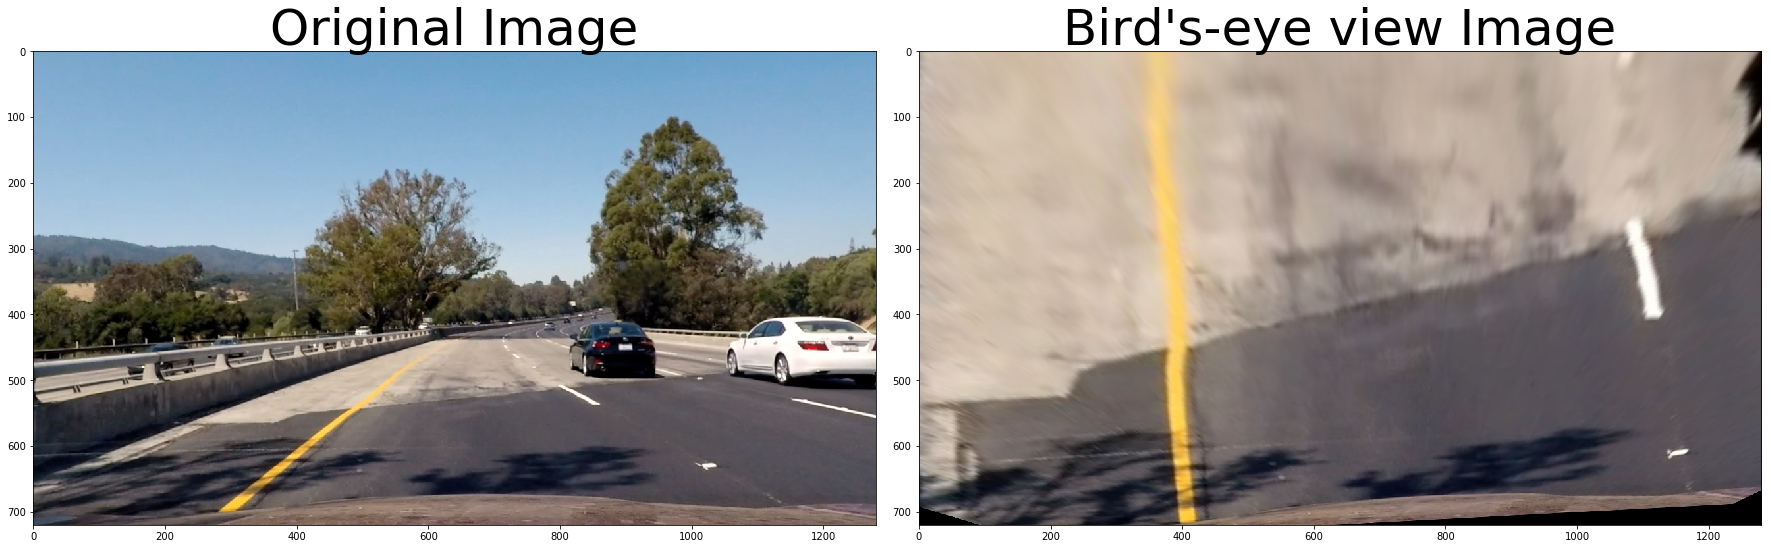

In [8]:
# Test and choose parameters
img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Undistort image
img = undistort(img)

# Transform
img_warp = warp(img)

print_image(img, img_warp, 'Original Image', "Bird's-eye view Image", 'default')

# Thresholding

The ultimate goal is the find the Lane Lines on the road, and there are numerous techniques an image can be thresholded to pick/emphasize a feature of it. Let's examine a few of these.
First let's implement the Sobel operator which takes the derivative of an image in either the x or y direction. 

# Sobel Threshold

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

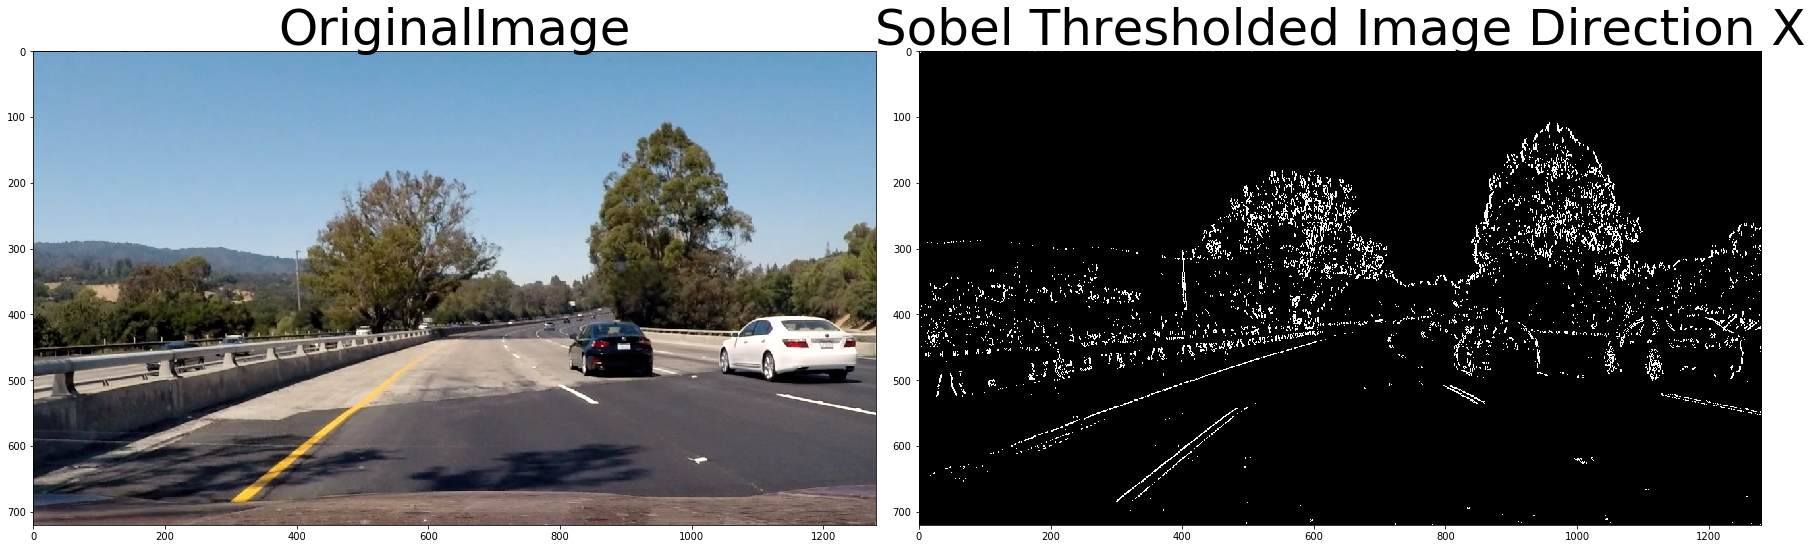

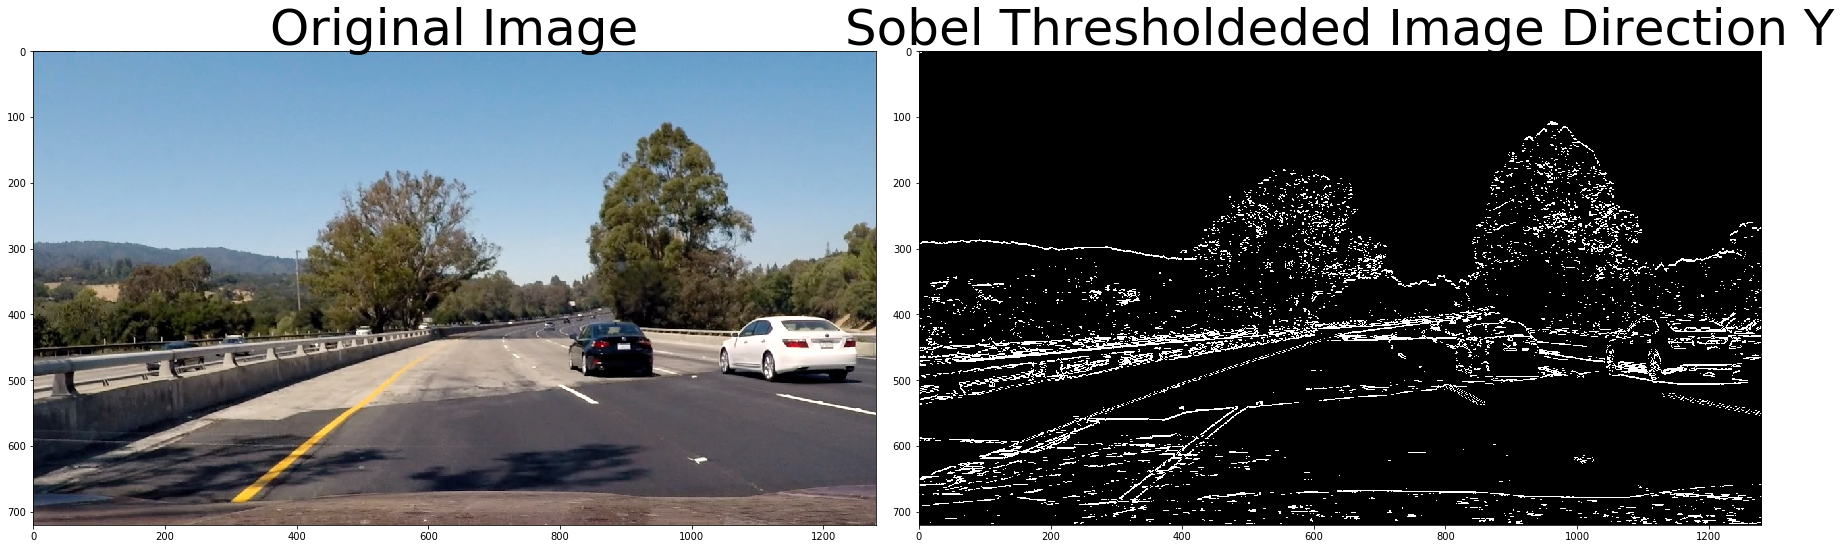

In [10]:
img = mpimg.imread('test_images/test4.jpg')
thresholded_img_x = abs_sobel_thresh(img, 'x', 30, 100)
thresholded_img_y = abs_sobel_thresh(img, 'y', 30, 100)
print_image(img, thresholded_img_x, 'OriginalImage', 'Sobel Thresholded Image Direction X', 'gray')
print_image(img, thresholded_img_y, 'Original Image', 'Sobel Thresholdeded Image Direction Y', 'gray')

# Magnitude Threshold

In [11]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

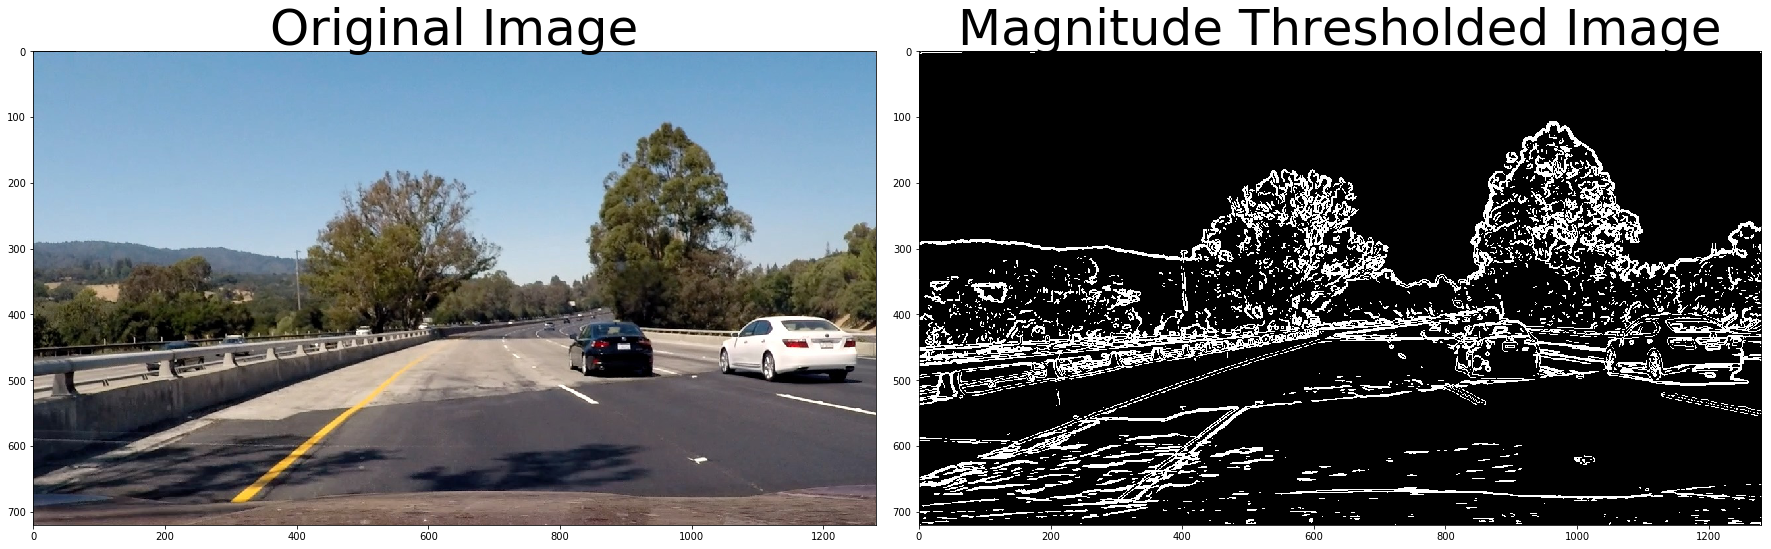

In [12]:
img = mpimg.imread('test_images/test4.jpg')
thresholded_img = mag_thresh(img, sobel_kernel=9, mag_thresh=(30,100))
print_image(img, thresholded_img, 'Original Image', 'Magnitude Thresholded Image', 'gray')

# Gradient Threshold

In [13]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

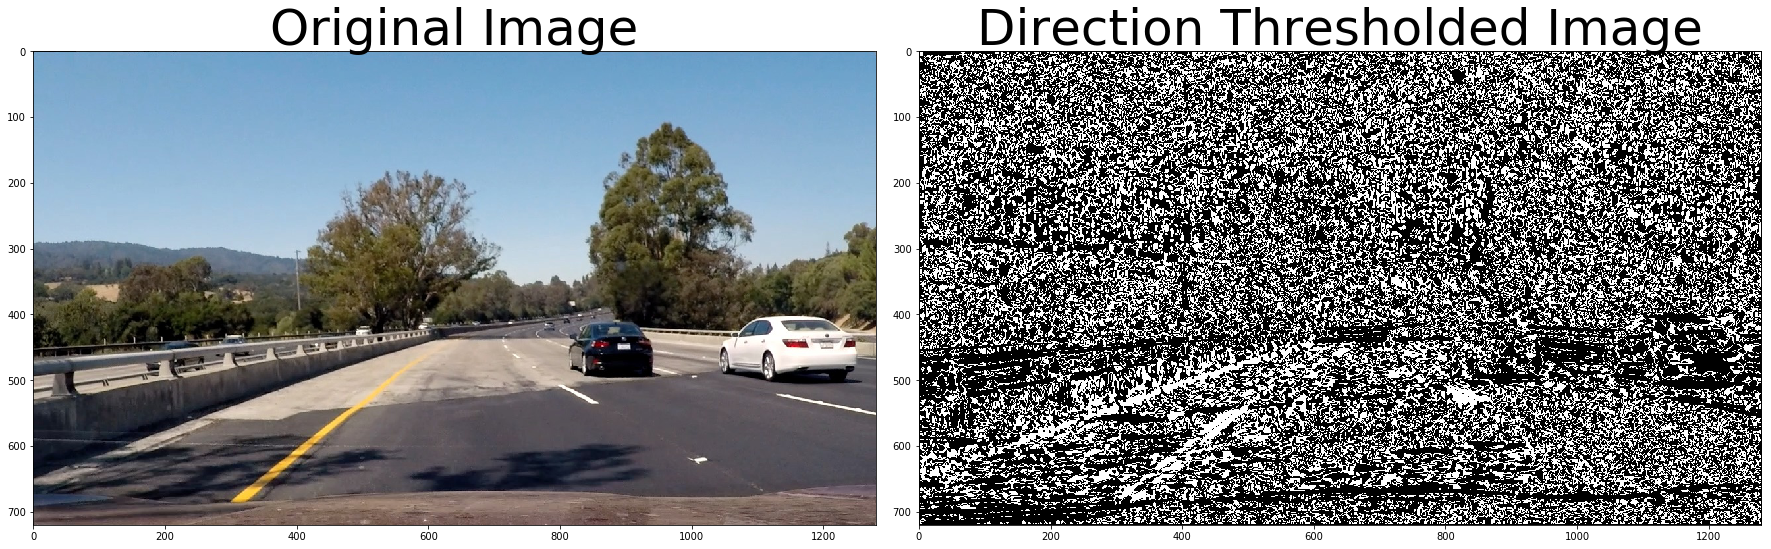

In [14]:
img = mpimg.imread('test_images/test4.jpg')
thresholded_img = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
print_image(img, thresholded_img, 'Original Image', 'Direction Thresholded Image', 'gray')

After experimenting numerous aspects of the gradient let's think about how we can use various aspects of the gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. Most importantly the question is how we can use thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines.

# Color Threshold

As it was shown in the Lessons there are various color thresholds that can be applied to find lane lines in images. It was also shown how and why the HLS color space can be more robust highlighting the lines regardless of lighting conditions, constrast, and other factors that might lead to recognize lanes in images incorrectly. Based on the examples in the Lessons I will apply the thresholding on the S-channel of the HLS image.

In [15]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

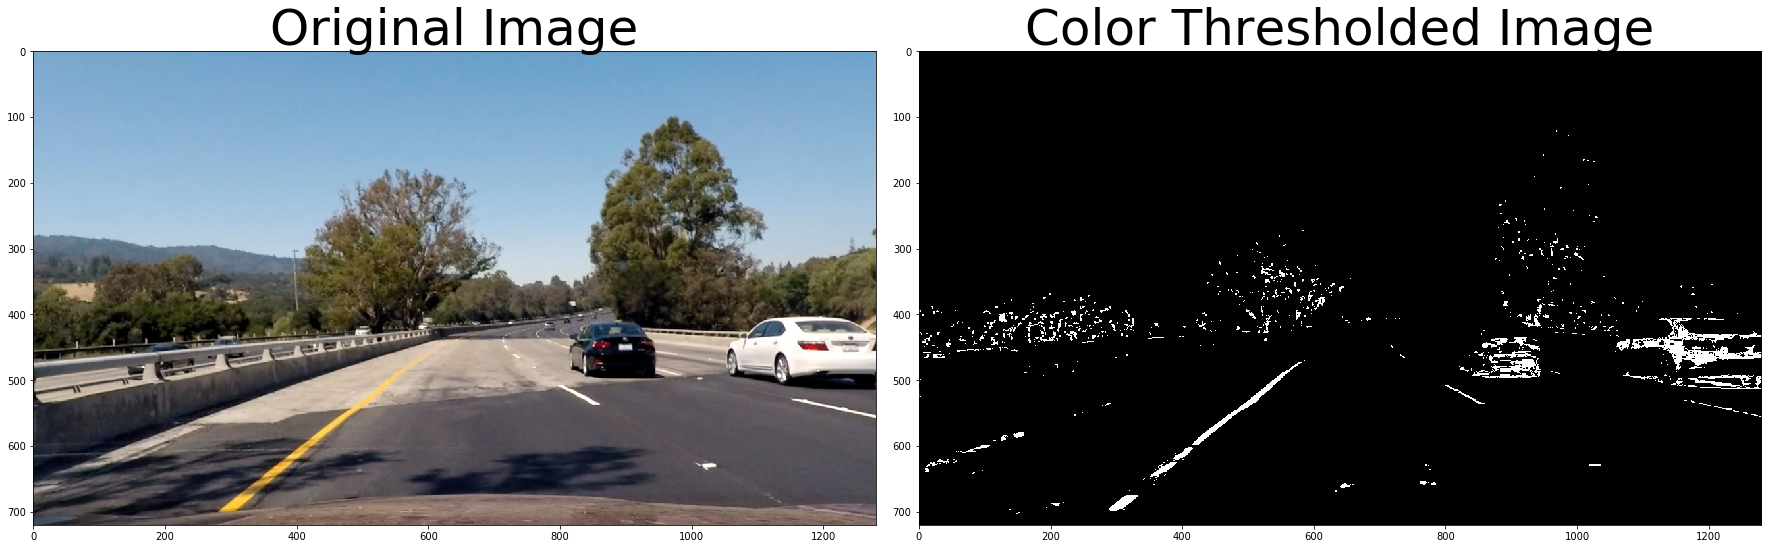

In [16]:
img = undistort(mpimg.imread('test_images/test4.jpg'))
s_channel_img = hls_select(img, thresh=(180,255))
print_image(img, s_channel_img, 'Original Image', 'Color Thresholded Image', cmap='gray')

# Thresholds Combined

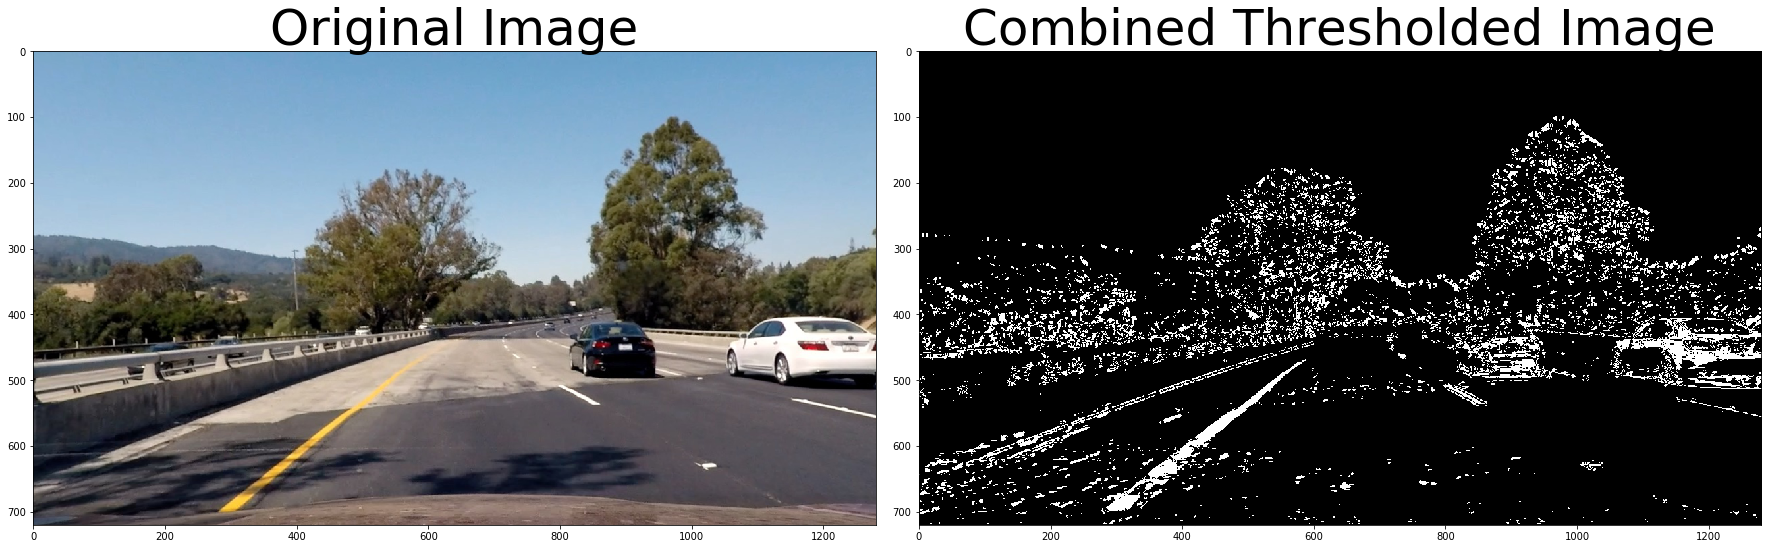

In [17]:
img = mpimg.imread('test_images/test4.jpg')

# Undistort image
img = undistort(img)

# Sobel threshold
gradx = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100)
grady = abs_sobel_thresh(img, orient='y', thresh_min=30, thresh_max=100)

# Magnitude threshold
mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(25, 100))

#Gradient threshold
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

#Color threshold
hls_binary = hls_select(img, (170, 255))

# Combine
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) | (hls_binary == 1))] = 1

# Plot
print_image(img, combined, 'Original Image', 'Combined Thresholded Image', 'gray')
    
